# Fishing for User Data in Large-Batch Federated Learning via Gradient Magnification


This notebook shows an example for a **arbitrary batch image gradient inversion** as described in "Fishing for User Data in Large-Batch Federated Learning via Gradient Magnification". The setting is a pretrained ResNet-18 and the federated learning algorithm is **fedSGD** in a **cross-device** setting.

Paper URL: https://arxiv.org/abs/2202.00580

This variant fishes for user data of the target user by estimating the feature distribution based on a group of other users. This is especially practical in a cross-device setting, where the server has access to many users.

#### Abstract
Federated learning (FL) has rapidly risen in popularity due to its promise of privacy and efficiency. Previous works have exposed privacy vulnerabilities in the FL pipeline by recovering user data from gradient updates. However, existing attacks fail to address realistic settings because they either 1) require a `toy' settings with very small batch sizes, or 2) require unrealistic and conspicuous architecture modifications. We introduce a new strategy that dramatically elevates existing attacks to operate on batches of arbitrarily large size, and without architectural modifications. Our model-agnostic strategy only requires modifications to the model parameters sent to the user, which is a realistic threat model in many scenarios. We demonstrate the strategy in challenging large-scale settings, obtaining high-fidelity data extraction in both cross-device and cross-silo federated learning.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case/server=malicious-fishing", "attack=april_analytic"])
          
device = torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
# In principle the attack can work with a normal split like this:
cfg.case.data.name = "ImageNet"
cfg.case.data.examples_from_split = "training"
cfg.case.data.default_clients = 56
cfg.case.server.target_cls_idx = 2 # Which class to attack?

cfg.case.user.num_data_points = 16
# but we partition only into data from this class to speed things up:
with open_dict(cfg):
    cfg.case.data.partition = "feat_est"
    cfg.case.data.num_data_points = cfg.case.user.num_data_points
    cfg.case.data.target_label = cfg.case.server.target_cls_idx

cfg.case.user.user_idx = 0
cfg.case.user.provide_labels = True # Mostly out of convenience

cfg.case.model="vit_small_april"

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture vit_small_april loaded with 22,049,896 parameters and 0 buffers.
Overall this is a data ratio of       9:1 for target shape [16, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 16

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNet
    user: 0
    
        
Server (of type MaliciousClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: vit_small_april
        model state: default
        

    Secrets: {}
    
Attacker (of type AprilAttacker).


### Simulate an attacked FL protocol

In this scenario, other users also exist, which we simulate below:

In [5]:
additional_users = []
for user_idx in range(1, cfg.case.data.default_clients): # The target user is user 0
    cfg.case.user.user_idx = user_idx
    extra_user = breaching.cases.construct_user(model, loss_fn, cfg.case, setup)
    additional_users += [extra_user]

We then run a modified server protocol, which first finds the feature by querying the other users and attacks the user ith a modified parameter vector based on the feature distribution gauged from the other users:

In [6]:
[shared_data], [server_payload], true_user_data = server.run_protocol_feature_estimation(user, additional_users)

Estimating feature distribution based on 55 given additional users.
Computing user update on user 1 in model mode: eval.
Computing user update on user 2 in model mode: eval.
Computing user update on user 3 in model mode: eval.
Computing user update on user 4 in model mode: eval.
Computing user update on user 5 in model mode: eval.
Computing user update on user 6 in model mode: eval.
Computing user update on user 7 in model mode: eval.
Computing user update on user 8 in model mode: eval.
Computing user update on user 9 in model mode: eval.
Computing user update on user 10 in model mode: eval.
Computing user update on user 11 in model mode: eval.
Computing user update on user 12 in model mode: eval.
Computing user update on user 13 in model mode: eval.
Computing user update on user 14 in model mode: eval.
Computing user update on user 15 in model mode: eval.
Computing user update on user 16 in model mode: eval.
Computing user update on user 17 in model mode: eval.
Computing user update o

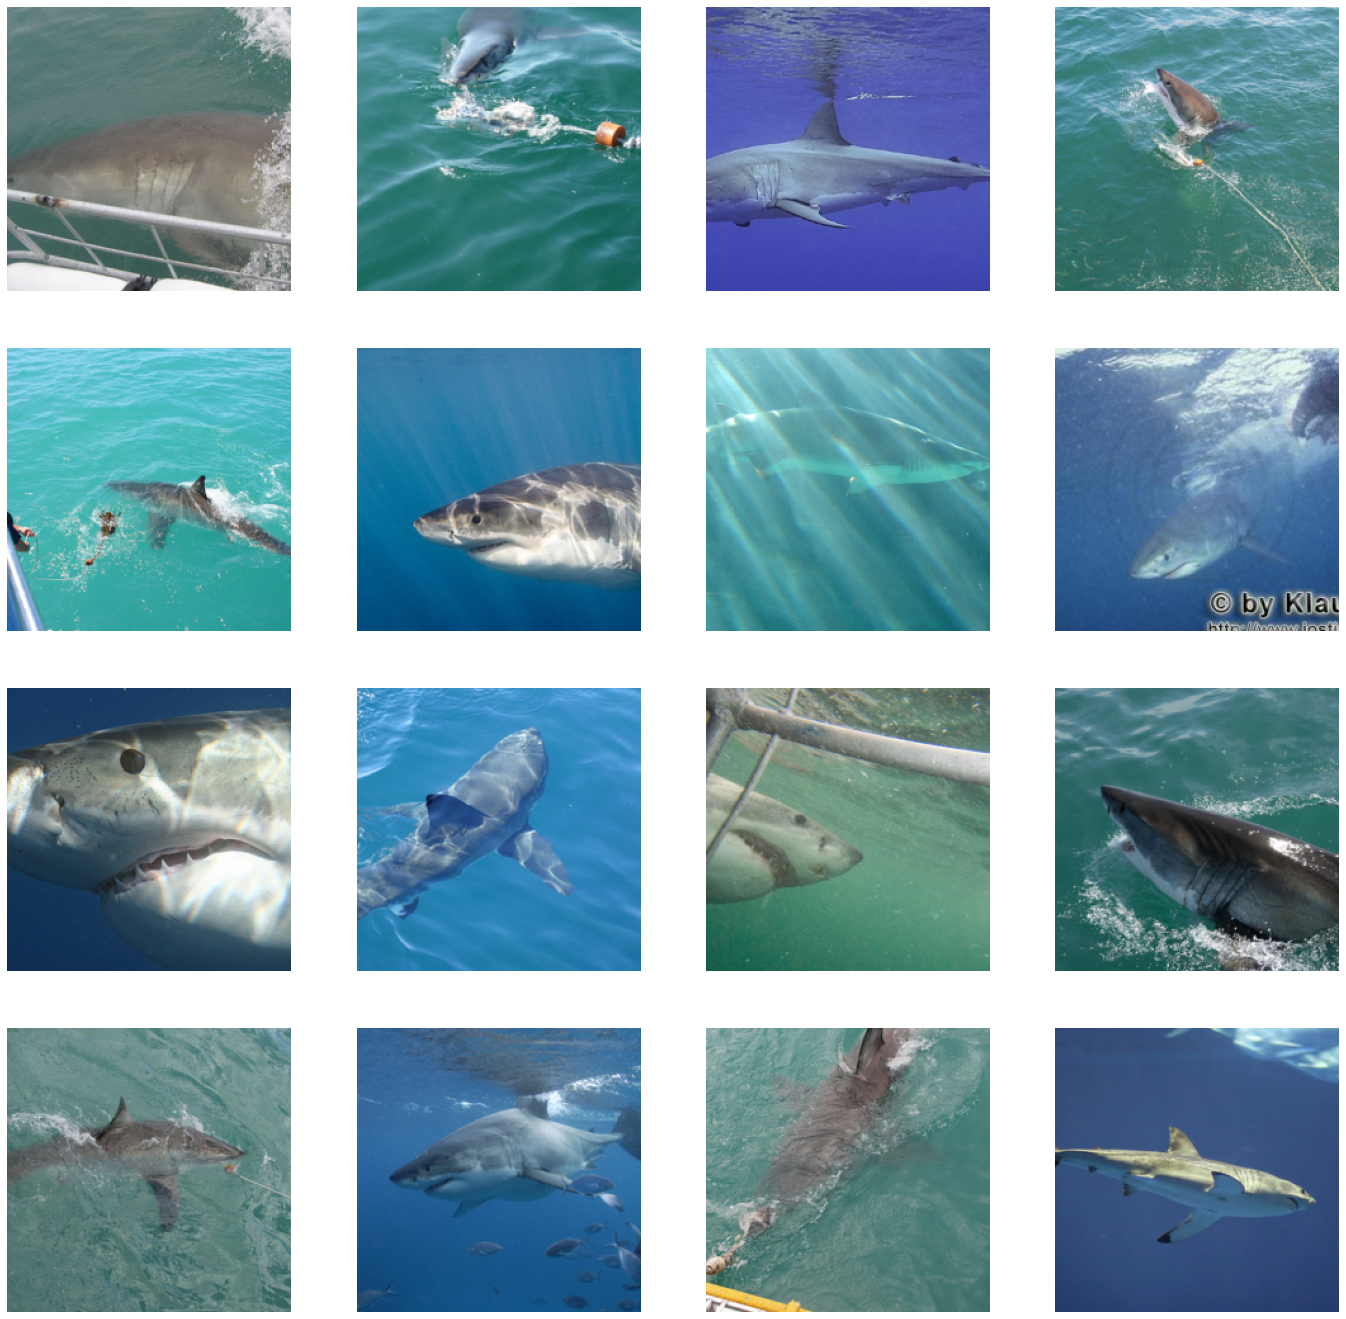

In [7]:
user.plot(true_user_data)

#### We can also evaluate the measured feature distribution:

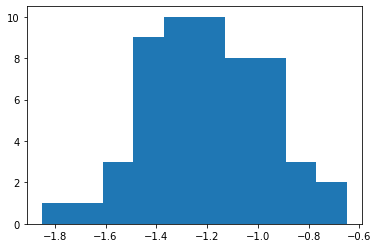

In [8]:
plt.hist(true_user_data["distribution"]);

In [9]:
from breaching.cases.malicious_modifications.classattack_utils import print_gradients_norm, cal_single_gradients
single_gradients, single_losses = cal_single_gradients(user.model, loss_fn, true_user_data, setup=setup)
print_gradients_norm(single_gradients, single_losses)

grad norm   |   loss
0.0000 | 0.00
63145.5742 | 86.81
0.0000 | 0.00
68877.4453 | 138.58
0.0000 | 0.00
0.0000 | 0.00
0.0000 | 0.00
0.0000 | 0.00
0.0000 | 0.00
0.0000 | 0.00
0.0000 | 0.00
0.0000 | 0.00
0.0000 | 0.00
53882.0781 | 179.62
56017.6641 | 31.65
0.0000 | 0.00


### Now reconstruct  a single "fished" user data point:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [10]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

Attention Inversion:  ||A||=49.13713942215149, ||b||=1665.8831504599073
Embedding Inversion:  ||A||=26.28605416331349, ||b||=121595.82287370556


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [11]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0534 | PSNR: 13.76 | FMSE: 7.2151e-01 | LPIPS: 0.93|
 R-PSNR: 14.42 | IIP-pixel: 0.00% | SSIM: 0.0144 | max R-PSNR: 19.24 | max SSIM: 0.1713 | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

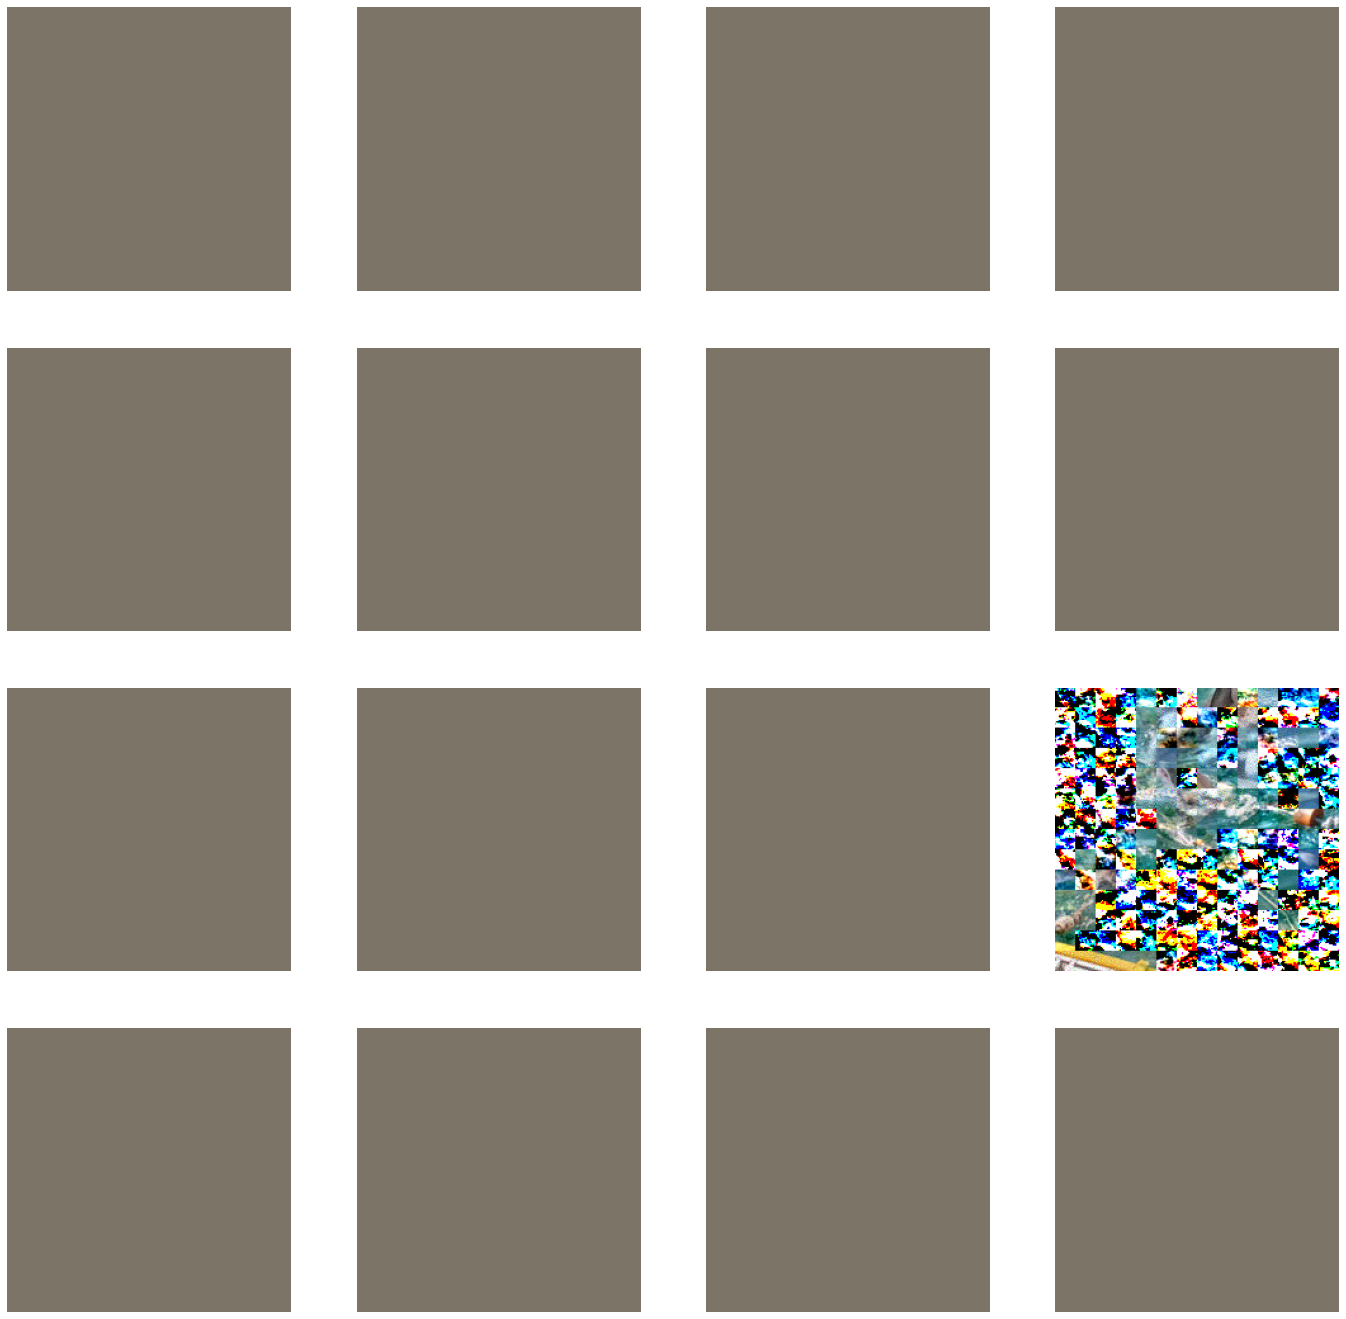

In [12]:
user.plot(reconstructed_user_data)

### Notes:
* You can use `cal_single_gradients` and `print_gradients_norm` from `breaching.cases.classattack_utils` to verify that only one of the user data points has a non-neglible gradient norm
* This attack has a $1/e \approx 37\%$ success chance for a single target user. Do not be alarmed if it does not work immediately (In those casese the reconstruction may return NaN immediately). In the cross-device setting, the attack can be deployed against a large number of users.
* This example shows the attack in a (fast to compute) setting where each user has only 4 goldfish images. You can also launch this attack in the general setting where each user has a large amount of data (and for example, the same number of goldfish images among them, or also much more), by tweaking the data settings and waiting longer. 